In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

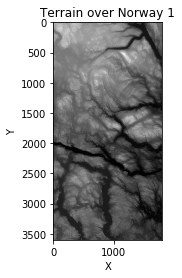

In [3]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [7]:
terrain1.shape

(3601, 1801)